In [21]:
import sys
sys.path.append('../')
import numpy as np
import chemometrics as cm
import matplotlib.pyplot as plt

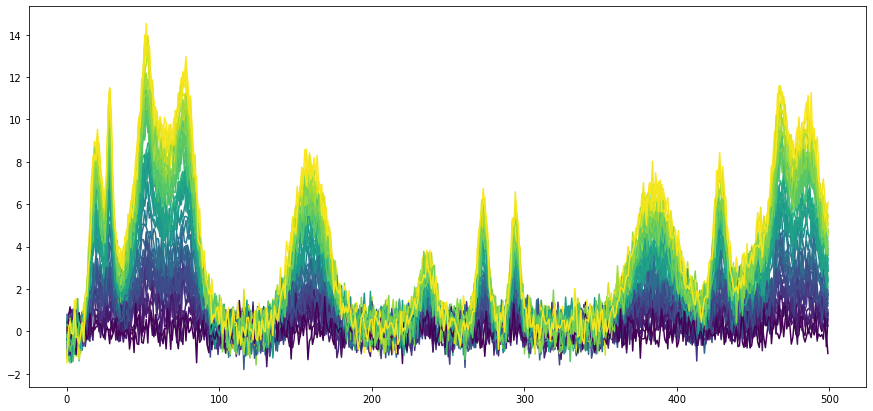

In [12]:
n_wl = 500
n_band = 20
bandwidth = 3
n_samples = 50
S = cm.generate_background(n_wl)*5 + cm.generate_spectra(n_wl, n_band,
                                                       bandwidth)
C = np.random.uniform(size=n_samples)
X = C[:,None] * S
X = X + np.random.normal(size=X.shape, scale=0.5)

plt.figure(figsize=(15, 7))
lines = cm.plot_colored_series(X.T, reference=C)

[]

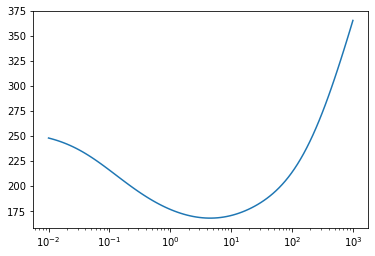

In [22]:
n_points = 100

penalties = 10**np.linspace(-2, 3, n_points)
scores = np.zeros(penalties.shape)

whittaker = cm.Whittaker(penalty=1)

for i in range(n_points):
    whittaker.penalty_ = penalties[i]
    whittaker.fit(X)
    scores[i] = whittaker.score(X)
    
plt.plot(penalties, scores,)
ax = plt.gca()
ax.semilogx()


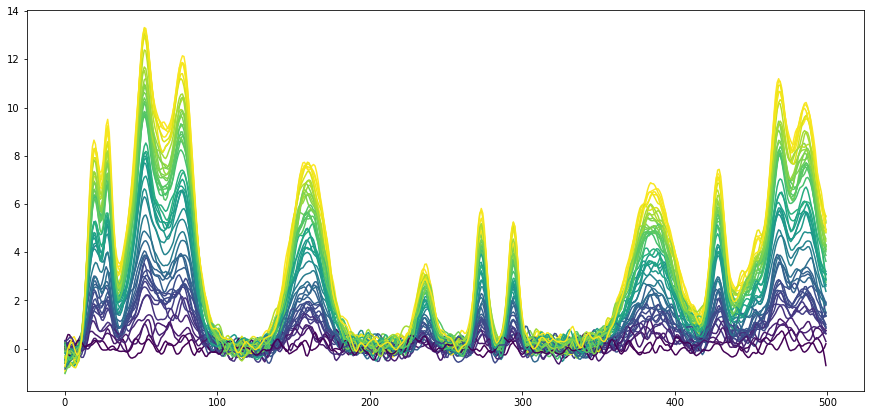

In [23]:
whittaker = cm.Whittaker()
X_smoothed = whittaker.fit_transform(X)
plt.figure(figsize=(15, 7))
lines = cm.plot_colored_series(X_smoothed.T, reference=C)

In [16]:
whittaker.penalty_

4.5231388554737